# Library Import

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import plot_roc_curve, mean_squared_error, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate
from IPython.display import display_html
import shap

# Import data and clean it for use with SKLearn

#### Of interesting note, SKLearn doesn't deal with strings. In this data set it is easy enough to pull the B off of the branch variable and go from there. Also, fill NAs with -1 instead of missing for same reason.

In [4]:
df = pd.read_csv('C:/Users/erikc/Desktop/insurance_t.csv')
df2 = pd.read_csv('C:/Users/erikc/Desktop/insurance_t.csv')
df3 = pd.read_csv('C:/Users/erikc/Desktop/insurance_v.csv')

df['BRANCH'] = df['BRANCH'].str.replace('B', '')
df2['BRANCH'] = df2['BRANCH'].str.replace('B', '')
df3['BRANCH'] = df3['BRANCH'].str.replace('B', '')

df.fillna(value = -1, inplace=True)
df2.fillna(value = -1, inplace=True)
df3.fillna(value = -1, inplace=True)

df['BRANCH'] = df['BRANCH'].astype(int)
df2['BRANCH'] = df2['BRANCH'].astype(int)
df3['BRANCH'] = df3['BRANCH'].astype(int)

# EDA

In [5]:
df.info()

df.describe()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495 entries, 0 to 8494
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ACCTAGE  8495 non-null   float64
 1   DDA      8495 non-null   int64  
 2   DDABAL   8495 non-null   float64
 3   DEP      8495 non-null   int64  
 4   DEPAMT   8495 non-null   float64
 5   CHECKS   8495 non-null   int64  
 6   DIRDEP   8495 non-null   int64  
 7   NSF      8495 non-null   int64  
 8   NSFAMT   8495 non-null   float64
 9   PHONE    8495 non-null   float64
 10  TELLER   8495 non-null   int64  
 11  SAV      8495 non-null   int64  
 12  SAVBAL   8495 non-null   float64
 13  ATM      8495 non-null   int64  
 14  ATMAMT   8495 non-null   float64
 15  POS      8495 non-null   float64
 16  POSAMT   8495 non-null   float64
 17  CD       8495 non-null   int64  
 18  CDBAL    8495 non-null   int64  
 19  IRA      8495 non-null   int64  
 20  IRABAL   8495 non-null   float64
 21  INV      8495 

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,CCPURC,SDB,INCOME,LORES,HMVAL,AGE,CRSCORE,INAREA,INS,BRANCH
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1.0,0,4.0,7.0,87.0,51.0,674.0,1,0,2
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,0.0,0,30.0,8.5,97.0,60.0,640.0,1,1,3
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,0.0,0,19.0,3.0,107.0,55.0,662.0,1,1,7
3,0.8,1,190.03,3,880.25,1,0,1,5.65,-1.0,...,-1.0,1,20.0,4.0,107.0,40.0,642.0,1,0,14
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,-1.0,...,-1.0,0,24.0,8.5,95.0,54.0,732.0,1,0,15


# Create variables for use with Random Forest Model

#### These variables will be used in portions of XGBoost modeling that follows later in this notebook. We will also initialize a set of x variables that include a random variable for variable selection in later steps.

In [6]:
df2['randNumCol'] = np.random.randint(1, 25, df.shape[0])

x = df.drop(['INS'], axis = 1)
y = df['INS']

x1 = df2.drop(['INS'], axis = 1)
y1 = df2['INS']

folds=10

print(x1.info())
print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495 entries, 0 to 8494
Data columns (total 38 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ACCTAGE     8495 non-null   float64
 1   DDA         8495 non-null   int64  
 2   DDABAL      8495 non-null   float64
 3   DEP         8495 non-null   int64  
 4   DEPAMT      8495 non-null   float64
 5   CHECKS      8495 non-null   int64  
 6   DIRDEP      8495 non-null   int64  
 7   NSF         8495 non-null   int64  
 8   NSFAMT      8495 non-null   float64
 9   PHONE       8495 non-null   float64
 10  TELLER      8495 non-null   int64  
 11  SAV         8495 non-null   int64  
 12  SAVBAL      8495 non-null   float64
 13  ATM         8495 non-null   int64  
 14  ATMAMT      8495 non-null   float64
 15  POS         8495 non-null   float64
 16  POSAMT      8495 non-null   float64
 17  CD          8495 non-null   int64  
 18  CDBAL       8495 non-null   int64  
 19  IRA         8495 non-null  

# Create Random Forest Model

#### First we'll check the paramters that we can tune, and which we will leave as default.

In [7]:
rf = rfc(random_state = 13)

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

#### Utilizing SKLearn's RandomizedSearchCV allows an analyst to feed a model into it and cross validate across parameters to choose the optimal set of parameters that we are trying to tune. We'll tune max_depth, min_samples_leaf, and n_estimators

In [8]:
params_rfc = {'max_depth': [1,2,3,4,5], 'min_samples_leaf': [10, 15, 20, 25], 
          'n_estimators': [100, 200, 300, 400, 500]}

skf_rfc = StratifiedKFold(n_splits=folds, shuffle=True, random_state=13)

clf = rfc(oob_score = True, max_features = 'auto', random_state=13)

rfc_search = GridSearchCV(clf, param_grid = params_rfc, scoring = 'roc_auc', n_jobs = 4, 
                          cv = skf_rfc.split(x,y), verbose = 3)

a = rfc_search.fit(x,y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


#### Grab the best parameters from our grid search.

In [9]:
a.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 500}

#### Check to see what the best ROC AUC was from the iterations in RandomizedSearchCV

In [10]:
a.best_score_

0.7841956238009422

#### Run the Random Forest Classifier again but now with our optimized parameters

In [11]:
clf_1 = rfc(n_estimators = 500, oob_score = True, max_features = 'auto', 
          random_state = 13, min_samples_leaf = 20, max_depth = 5)

b = clf_1.fit(x,y)

#### Out of Bag Score

In [12]:
print(b.oob_score_)

0.7241907004120071


#### Get feature importances for the estimators as well as the names of the variables. By putting them both in a dataframe, we can concatenate them in the following step

In [13]:
cols = pd.DataFrame(x.columns, columns = ['Features'])

c = pd.DataFrame(b.feature_importances_, columns = ['Importance'])

#### Concatenate the DFs built above, adding in combining feature names with their importance.

In [14]:
d = pd.concat([cols, c], join='outer', axis=1)

e = tabulate(d.sort_values(by='Importance', ascending=False), headers = d.columns, tablefmt = 'psql')

print(e)

+----+------------+--------------+
|    | Features   |   Importance |
|----+------------+--------------|
| 12 | SAVBAL     |  0.277719    |
|  2 | DDABAL     |  0.128082    |
| 18 | CDBAL      |  0.0987414   |
| 17 | CD         |  0.073195    |
|  1 | DDA        |  0.059066    |
| 24 | MMBAL      |  0.0484558   |
| 23 | MM         |  0.0426516   |
|  4 | DEPAMT     |  0.0358219   |
| 11 | SAV        |  0.0284973   |
|  3 | DEP        |  0.0225113   |
| 26 | CC         |  0.0214128   |
| 14 | ATMAMT     |  0.0212421   |
| 20 | IRABAL     |  0.0186618   |
| 19 | IRA        |  0.0165186   |
|  5 | CHECKS     |  0.0119853   |
| 27 | CCBAL      |  0.0108335   |
| 36 | BRANCH     |  0.00990967  |
| 21 | INV        |  0.00790787  |
| 13 | ATM        |  0.00634588  |
| 32 | HMVAL      |  0.00620465  |
|  0 | ACCTAGE    |  0.00581309  |
| 10 | TELLER     |  0.00526404  |
|  9 | PHONE      |  0.00500496  |
| 34 | CRSCORE    |  0.00492499  |
| 30 | INCOME     |  0.00474173  |
| 16 | POSAMT     | 

#### Plot the ROC Curve

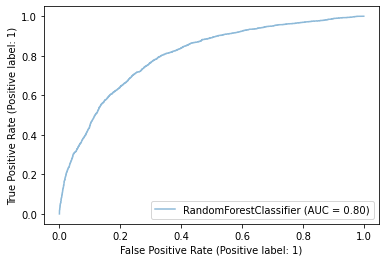

In [15]:
ax = plt.gca()

rfc_disp = plot_roc_curve(b, x, y, ax=ax, alpha=0.5)

#### Same steps as above but with random integer variable so that we can see if there is variable selection that needs doing.

In [16]:
b1 = clf_1.fit(x1,y1)

cols1 = pd.DataFrame(x1.columns, columns = ['Features'])
c1 = pd.DataFrame(b1.feature_importances_, columns = ['Importance'])


d1 = pd.concat([cols1, c1], join='outer', axis=1)
e1 = tabulate(d1.sort_values(by='Importance', ascending=False), headers = d1.columns, tablefmt = 'psql')

print(e1)

+----+------------+--------------+
|    | Features   |   Importance |
|----+------------+--------------|
| 12 | SAVBAL     |  0.271132    |
|  2 | DDABAL     |  0.122696    |
| 18 | CDBAL      |  0.109659    |
| 17 | CD         |  0.0629749   |
|  1 | DDA        |  0.0578503   |
| 24 | MMBAL      |  0.0470111   |
| 23 | MM         |  0.0414778   |
|  4 | DEPAMT     |  0.0383359   |
| 11 | SAV        |  0.0353322   |
|  3 | DEP        |  0.0247692   |
| 26 | CC         |  0.022466    |
| 14 | ATMAMT     |  0.0221595   |
| 20 | IRABAL     |  0.0219283   |
| 19 | IRA        |  0.015281    |
| 27 | CCBAL      |  0.0106757   |
|  5 | CHECKS     |  0.0102356   |
| 36 | BRANCH     |  0.00878921  |
| 32 | HMVAL      |  0.0074144   |
|  0 | ACCTAGE    |  0.00684489  |
| 13 | ATM        |  0.00673511  |
| 21 | INV        |  0.00667763  |
|  9 | PHONE      |  0.00524139  |
| 28 | CCPURC     |  0.00514793  |
| 34 | CRSCORE    |  0.00508126  |
| 33 | AGE        |  0.00418664  |
| 30 | INCOME     | 

# XGBoost Modeling

#### We will reuse x, y as well as folds from above. We are also going to use GridSearchCV as well to grid tune our XGBoost Classifier model.

In [17]:
params = {'max_depth': [1,2,3,4,5], 'eta': [0.1,0.15,0.2,0.25,0.3], 
          'subsample': [0.25,0.5,0.75,1]}

skf_xgb = StratifiedKFold(n_splits=folds, shuffle=True, random_state=13)


bst = xgb.XGBClassifier(learning_rate=0.02, objective='binary:logistic', n_estimators = 500, 
                        eval_metric='rmse', gamma=0, colsample_bytree=1, min_child_weight=1)

xgb_search = GridSearchCV(bst, param_grid=params, scoring='roc_auc', n_jobs=4, 
                                   cv=skf_xgb.split(x,y), verbose=3)

f = xgb_search.fit(x,y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


#### Grab the best parameters from our tuning stage.

In [18]:
f.best_params_

{'eta': 0.1, 'max_depth': 4, 'subsample': 0.5}

#### See what the best ROC AUC was from our tuning iterations.

In [19]:
xgb_search.best_score_

0.804600841589355

#### Refit XGBClassifier with freshly tuned parameters

In [20]:
bst_1 = xgb.XGBClassifier(learning_rate=0.02, objective='binary:logistic', subsample = 0.5, 
                        max_depth = 4, eta = 0.1, n_estimators = 25, eval_metric='auc', random_state = 13)

g = bst_1.fit(x,y)

#### Get feature importances from both versions of our fit. G1 contains the random integer variable we created.

In [21]:
h = pd.DataFrame(g.feature_importances_, columns = ['Importance'])

#### Concatenate them and make them a pretty table purely for looks.

In [22]:
i = pd.concat([cols, h], join='outer', axis=1)

e = tabulate(d.sort_values(by='Importance', ascending=False), headers = i.columns, tablefmt = 'psql')

print(e)

+----+------------+--------------+
|    | Features   |   Importance |
|----+------------+--------------|
| 12 | SAVBAL     |  0.277719    |
|  2 | DDABAL     |  0.128082    |
| 18 | CDBAL      |  0.0987414   |
| 17 | CD         |  0.073195    |
|  1 | DDA        |  0.059066    |
| 24 | MMBAL      |  0.0484558   |
| 23 | MM         |  0.0426516   |
|  4 | DEPAMT     |  0.0358219   |
| 11 | SAV        |  0.0284973   |
|  3 | DEP        |  0.0225113   |
| 26 | CC         |  0.0214128   |
| 14 | ATMAMT     |  0.0212421   |
| 20 | IRABAL     |  0.0186618   |
| 19 | IRA        |  0.0165186   |
|  5 | CHECKS     |  0.0119853   |
| 27 | CCBAL      |  0.0108335   |
| 36 | BRANCH     |  0.00990967  |
| 21 | INV        |  0.00790787  |
| 13 | ATM        |  0.00634588  |
| 32 | HMVAL      |  0.00620465  |
|  0 | ACCTAGE    |  0.00581309  |
| 10 | TELLER     |  0.00526404  |
|  9 | PHONE      |  0.00500496  |
| 34 | CRSCORE    |  0.00492499  |
| 30 | INCOME     |  0.00474173  |
| 16 | POSAMT     | 

#### Plot the ROC curve and get AUC from the plot.

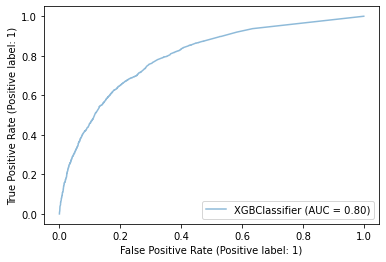

In [23]:
ax = plt.gca()

xgb_disp = plot_roc_curve(g, x, y, ax=ax, alpha=0.5)

#### Repeat the same steps from above but with the random number for potential variable selection

In [24]:
g1 = bst_1.fit(x1,y1)

h1 = pd.DataFrame(g1.feature_importances_, columns = ['Importance'])

i1 = pd.concat([cols1, h1], join='outer', axis=1)

e1 = tabulate(d1.sort_values(by='Importance', ascending=False), headers = i.columns, tablefmt = 'psql')

print(e1)

+----+------------+--------------+
|    | Features   |   Importance |
|----+------------+--------------|
| 12 | SAVBAL     |  0.271132    |
|  2 | DDABAL     |  0.122696    |
| 18 | CDBAL      |  0.109659    |
| 17 | CD         |  0.0629749   |
|  1 | DDA        |  0.0578503   |
| 24 | MMBAL      |  0.0470111   |
| 23 | MM         |  0.0414778   |
|  4 | DEPAMT     |  0.0383359   |
| 11 | SAV        |  0.0353322   |
|  3 | DEP        |  0.0247692   |
| 26 | CC         |  0.022466    |
| 14 | ATMAMT     |  0.0221595   |
| 20 | IRABAL     |  0.0219283   |
| 19 | IRA        |  0.015281    |
| 27 | CCBAL      |  0.0106757   |
|  5 | CHECKS     |  0.0102356   |
| 36 | BRANCH     |  0.00878921  |
| 32 | HMVAL      |  0.0074144   |
|  0 | ACCTAGE    |  0.00684489  |
| 13 | ATM        |  0.00673511  |
| 21 | INV        |  0.00667763  |
|  9 | PHONE      |  0.00524139  |
| 28 | CCPURC     |  0.00514793  |
| 34 | CRSCORE    |  0.00508126  |
| 33 | AGE        |  0.00418664  |
| 30 | INCOME     | 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


# Take the model to the validation set

In [25]:
x_v = df3.drop(['INS'], axis = 1)
y_v = df3['INS']

#### Fit the model with variables created above from the validation set

In [26]:
bst_v = xgb.XGBClassifier(learning_rate=0.02, objective='binary:logistic', subsample = 0.5, 
                        max_depth = 4, eta = 0.1, n_estimators = 25, eval_metric='auc', random_state = 13)

q = bst_v.fit(x_v,y_v)

#### ROC Curve

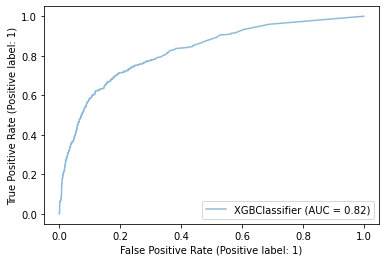

In [27]:
ax = plt.gca()

xgb_disp1 = plot_roc_curve(q, x_v, y_v, ax=ax, alpha=0.5)

#### Partial dependence plot for ACCTAGE

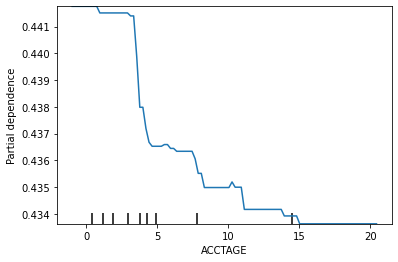

In [28]:
from sklearn.inspection import plot_partial_dependence

disp_v = plot_partial_dependence(q, x_v, [0])

#### Feature importances

In [29]:
r = pd.DataFrame(q.feature_importances_, columns = ['Importance'])

s = pd.concat([cols, h], join='outer', axis=1)

t = tabulate(s.sort_values(by='Importance', ascending=False), headers = i.columns, tablefmt = 'psql')

print(t)

+----+------------+--------------+
|    | Features   |   Importance |
|----+------------+--------------|
| 12 | SAVBAL     |   0.159819   |
| 23 | MM         |   0.140291   |
| 24 | MMBAL      |   0.137456   |
|  1 | DDA        |   0.125521   |
|  2 | DDABAL     |   0.0725955  |
| 19 | IRA        |   0.0455315  |
| 18 | CDBAL      |   0.0410005  |
| 27 | CCBAL      |   0.0186603  |
| 20 | IRABAL     |   0.0168636  |
|  9 | PHONE      |   0.0161411  |
| 16 | POSAMT     |   0.0156902  |
|  0 | ACCTAGE    |   0.0156685  |
| 36 | BRANCH     |   0.0153812  |
| 17 | CD         |   0.0153517  |
|  5 | CHECKS     |   0.0144107  |
| 21 | INV        |   0.0134873  |
| 32 | HMVAL      |   0.0118623  |
| 30 | INCOME     |   0.0115344  |
| 31 | LORES      |   0.0104121  |
|  4 | DEPAMT     |   0.0100864  |
|  3 | DEP        |   0.00998901 |
| 14 | ATMAMT     |   0.00998232 |
| 26 | CC         |   0.00991405 |
| 33 | AGE        |   0.00973343 |
| 15 | POS        |   0.00939875 |
| 28 | CCPURC     | 